In [1]:
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [2]:
def simulate(**kwargs):
  values = {}
  g = gr.Digraph()
  for k,v in kwargs.items():
    parents = v.__code__.co_varnames
    inputs = {arg: values[arg] for arg in parents}
    values[k] = v(**inputs)
    for p in parents:
        g.edge(p,k)
  data = pd.DataFrame(values)
  return data, g

In [3]:
np.random.seed(0)
N = 1000
df, g = simulate(
    X = lambda: np.random.binomial(1, 0.5, size=N),
    T = lambda X: np.random.normal(5*X, 1, size=N),
    Y = lambda X, T: 1 + 20*X - 2*T + np.random.normal(size=N)
)
df['X'] = df['X'].astype('category')

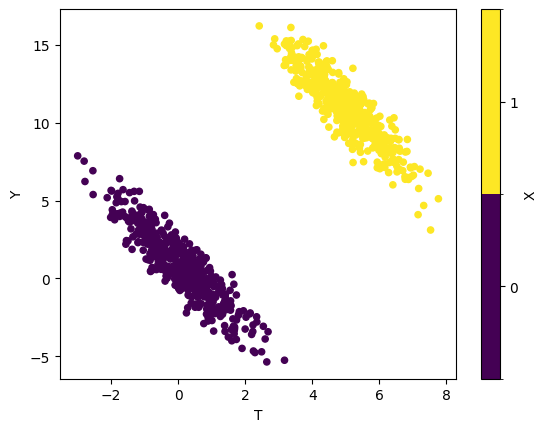

In [4]:
df.plot(x='T', y='Y', kind='scatter', c='X', cmap='viridis');
#plt.savefig('../scratch/graphs/simpsons_1.png')

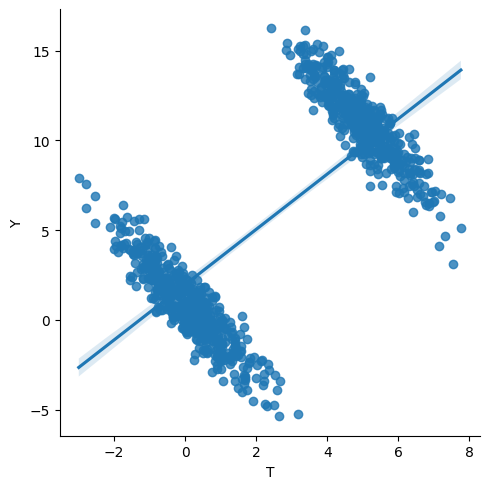

In [5]:
sns.lmplot(x='T', y='Y', data=df);
#plt.savefig('../scratch/graphs/simpsons_2.png')

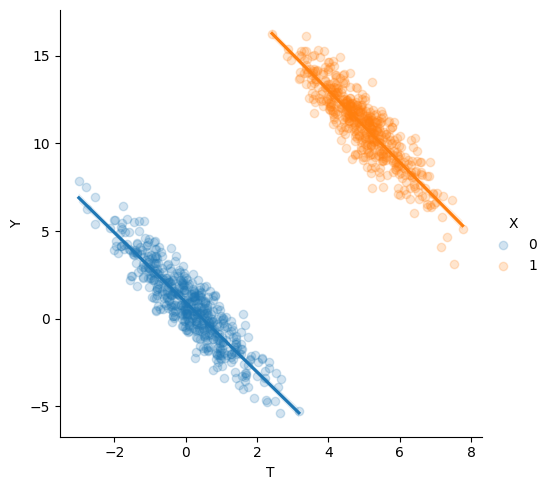

In [6]:
# We do get the correct slope if we do the regression separately for each value of X
sns.lmplot(x='T', y='Y', hue='X', data=df, scatter_kws={'alpha':0.2});
#plt.savefig('../scratch/graphs/simpsons_3.png')

In [7]:
# Seaborn directly supports 'partialing out' a variable
# Annoyingly, it doesn't support categorical variables
#df['X_continuous'] = df['X'].cat.codes
#sns.lmplot(x='T', y='Y', x_partial='X_continuous', y_partial='X_continuous', data=df);

In [8]:
# FWL partialization
#df['Y_pred'] = smf.ols('Y ~ X', data=df).fit().predict(df)
#df['T_pred'] = smf.ols('T ~ X', data=df).fit().predict(df)
df['Y_pred'] = LinearRegression().fit(df[['X']], df['Y']).predict(df[['X']])
df['T_pred'] = LinearRegression().fit(df[['X']], df['T']).predict(df[['X']])
df['Y_resid'] = df['Y'] - df['Y_pred']
df['T_resid'] = df['T'] - df['T_pred']

In [9]:
# Correct Full Regression
smf.ols('Y ~ X + T', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.9427,0.042,22.292,0.000,0.860,1.026
X[T.1],20.1212,0.166,121.526,0.000,19.796,20.446
T,-2.0172,0.031,-64.119,0.000,-2.079,-1.955


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.9684,0.165,11.952,0.000,1.645,2.292
T,1.5395,0.046,33.561,0.000,1.449,1.630


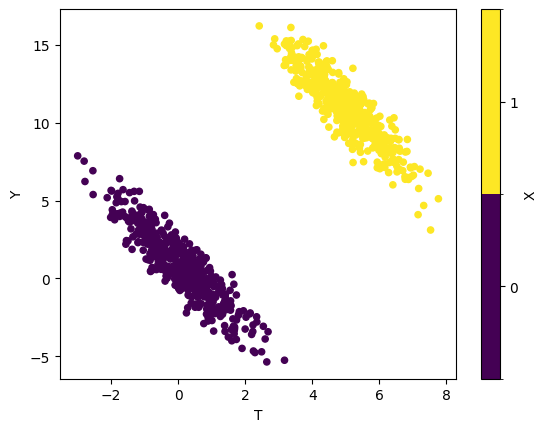

In [10]:
df.plot.scatter(x='T', y='Y', color='X', cmap='viridis');
smf.ols('Y ~ T', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.7310,0.165,34.760,0.000,5.407,6.055
T_resid,-2.0172,0.171,-11.804,0.000,-2.353,-1.682


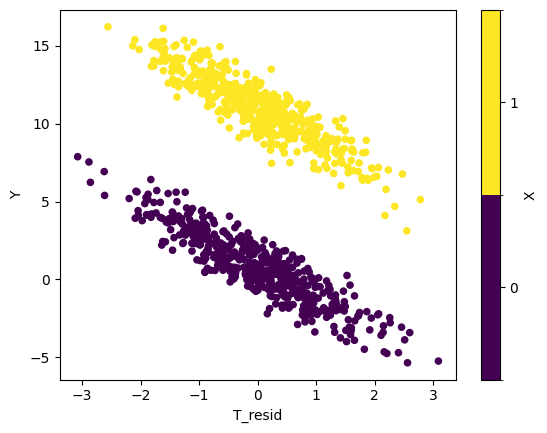

In [11]:
df.plot.scatter(x='T_resid', y='Y', color='X', cmap='viridis');
smf.ols('Y ~ T_resid', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6635,0.089,7.495,0.000,0.490,0.837
T,-0.2715,0.025,-11.010,0.000,-0.320,-0.223


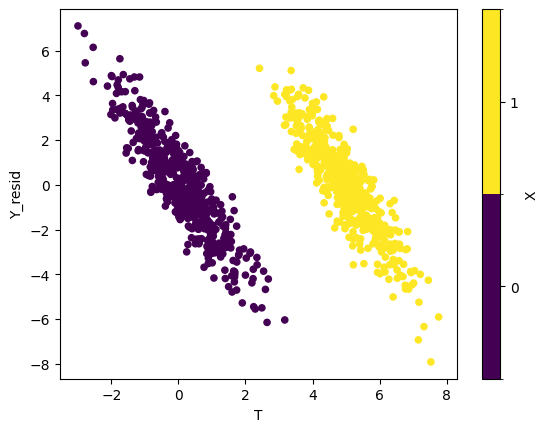

In [12]:
df.plot.scatter(x='T', y='Y_resid', color='X', cmap='viridis');
smf.ols('Y_resid ~ T', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.252e-15,0.030,-4.13e-14,1.000,-0.060,0.060
T_resid,-2.0172,0.031,-64.151,0.000,-2.079,-1.956


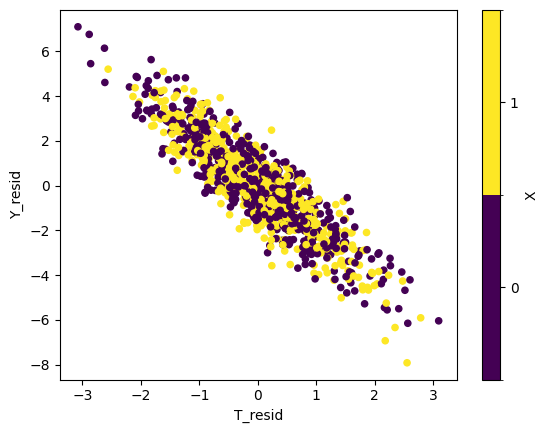

In [13]:
df.plot.scatter(x='T_resid', y='Y_resid', color='X', cmap='viridis');
smf.ols('Y_resid ~ T_resid', data=df).fit().summary().tables[1]